In [1]:
import numpy as np
from torchvision import datasets, transforms
from PIL import Image
from IPython.display import display
from model.unet import Unet
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
import os
from utils.utils import visualize
from utils.sample import ddpm_sample, ddim_sample

In [2]:
device = 'cuda'

unet = Unet(dim=128, mults=[1, 2, 4, 8], channel_scale=1).to(device)

In [3]:
total_timesteps = 1000
beta_0 = 0.0001
beta_T = 0.02
sampling_steps = 1000

def linear_beta_schedule(timesteps=1000):
    betas = torch.linspace(beta_0, beta_T, steps=timesteps+1, device=device)

    alphas = 1. - betas
    alphas_bar = torch.cumprod(alphas, dim=0)

    return betas, alphas, alphas_bar

betas, alphas, alphas_bar = linear_beta_schedule(total_timesteps)

In [4]:
unet.load_state_dict(torch.load("./logs_mnist/weights/model_118.pth"))

<All keys matched successfully>

In [5]:
from tqdm import tqdm

timesteps = torch.linspace(1000, 1, 1000).int().to(device)
do_clip = partial(torch.clamp, min = -1., max = 1.)

with torch.no_grad():
    x_t = torch.randn((8, 1, 32, 32)).to(device)
    for t in tqdm(timesteps):
        t = t.repeat(8)
        z = torch.randn_like(x_t).to(device)
        predict_noise = unet(x_t, t)
        x_t = ddpm_sample(x_t, t.int(), predict_noise, z, betas, alphas, alphas_bar)
        # x_t = do_clip(x_t)

100%|██████████| 1000/1000 [00:22<00:00, 44.75it/s]


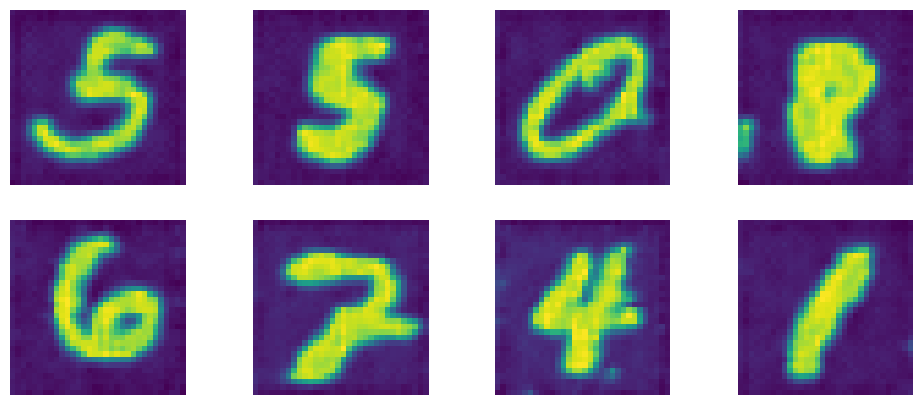

In [6]:
visualize(x_t.cpu().numpy(), save=False, chn=1)

In [5]:
from tqdm import tqdm

timesteps = torch.linspace(1000, 10, 100).int().to(device)
do_clip = partial(torch.clamp, min = -1., max = 1.)

with torch.no_grad():
    x_t = torch.randn((8, 1, 32, 32)).to(device)
    for t in tqdm(timesteps):
        t = t.repeat(8)
        predict_noise = unet(x_t, t)
        x_t = ddim_sample(x_t, t.int(), predict_noise, alphas_bar[t], alphas_bar[t-10])
        # x_t = do_clip(x_t)

100%|██████████| 100/100 [00:02<00:00, 41.88it/s]


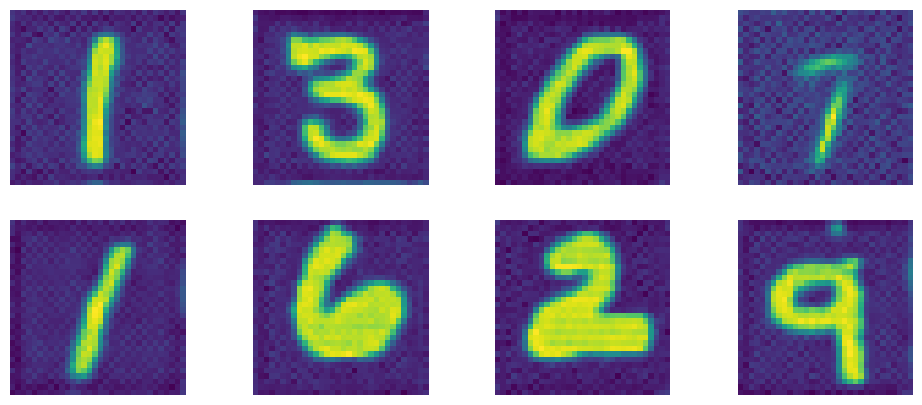

In [6]:
visualize(x_t.cpu().numpy()/2+0.5, save=False, chn=1)